## Imports

In [1]:
import pickle
import random
import os
from collections import Counter

import nltk
import pylab as plt
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.utils.data as data
from torch.nn.utils.rnn import pack_padded_sequence

from sklearn.metrics import hamming_loss
model_name = "Master ResNet-152"

## Data Preprocessing

### Loading The Data
In this section we load the HARRISON data set which we have extracted into the data directory

In [2]:
with open("data/HARRISON/data_list.txt") as f:
    data_list = f.read().splitlines()
with open("data/HARRISON/tag_list.txt") as f:
    tag_list = f.read().splitlines()

In [3]:
print(data_list[0])
print(tag_list[0])

instagram_dataset/sea/image_50.jpg
sea instapic instagram trip travel 


### Visualizing The Data

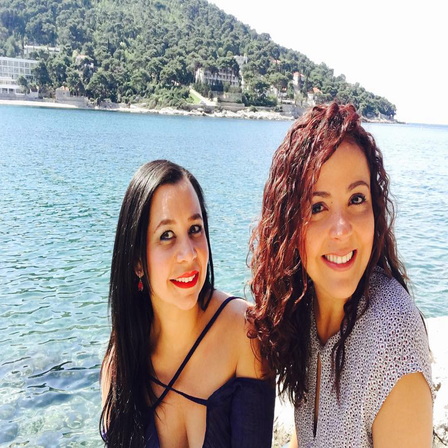

#sea, #instapic, #instagram, #trip, #travel


In [4]:
image = Image.open("data/HARRISON/" + data_list[0])
image = image.resize((448, 448), Image.ANTIALIAS)
display(image)
print("#" + ", #".join(tag_list[0].split(" "))[:-3])

### Creating A Vocabulary
A vocabulary object contains supports three main operations:
\begin{enumerate}
    \item Get the integer representation of a word
    \item Get the word representation of an integer
    \item Get the number of items in the vocabulary
\end{enumerate}
To build a vocabulary, call `build_vocabulary` and pass in a list of tagged sequences and the minimum number of times a tag must appear for it to be included in the vocabulary 

In [5]:
class Vocabulary(object):
    def __init__(self):
        self.word_to_index = {}
        self.index_to_word = []
        self.index = 0
    
    def add_word(self, word):
        if not word in self.word_to_index:
            self.word_to_index[word] = self.index
            self.index_to_word.append(word)
            self.index += 1
        else:
            raise ValueError("Word %s is already in the vocabulary!" %word)
    
    def __call__(self, word):
        if type(word) == str:
            if word not in self.word_to_index:
                return self.word_to_index["<UNK>"]
            return self.word_to_index[word]
        elif type(word) == int:
            if self.index <= word:
                raise ValueError("Index %s is out of bounds!" %word)
            return self.index_to_word[word]
        else:
            raise ValueError("Only strings and integers are accepted inputs!")
    
    def __len__(self):
        return self.index
    
def build_vocabulary(tag_list, min_occurrences, progress_bar=True):
    counter = Counter()
    for tags in (tqdm_notebook(tag_list) if progress_bar else tag_list):
        tokens = nltk.tokenize.word_tokenize(tags.lower())
        counter.update(tokens)
        
    # a word must appear at least min_occurrence times to be included in the vocabulary
    words = [word for word, count in counter.items() if count >= min_occurrences]
    
    # Creating the vocabulary object
    vocab = Vocabulary()
    vocab.add_word("<SOS>")
    vocab.add_word("<EOS>")
    vocab.add_word("<UNK>")
    
    # Adds the words from the captions to the vocabulary
    for word in words:
        vocab.add_word(word)
    return vocab

vocabulary = build_vocabulary(tag_list=[tags for tags in tag_list], min_occurrences=5)
print(len(vocabulary))

HBox(children=(IntProgress(value=0, max=57383), HTML(value=u'')))


997


### Batching The Data

Groups the images by the number of tags

The images are first grouped by their number of tags, then separated into batches of a user-specified size. The batched data is then separated into training and testing data, where 75% of the data is training and 25% is testing.

#### Batching The Data

The data is grouped by the number of tags associated with each image and separated within a `BatchedData` object, which handles holding batches of a specified `batch_size`. Each batch only holds images with the same number of tags and there are no batches that are smaller than `batch_size`.

In [6]:
batch_size = 32

class BatchedData(object):
    def __init__(self, batch_size):
        self.batched_data = []
        self.index = 0
        self.batch_size = batch_size

    def add_batch(self, batch):
        if len(batch) == self.batch_size:
            self.batched_data.append(batch)
        else:
            print("not the correct size batch!")

    def __call__(self, index):
        if not index < len(self.batched_data):
            return []
        return self.batched_data[index]

    def __len__(self):
        return len(self.batched_data)

def batch_data(tag_list, batch_size, progress_bar=True):
    batched_map = {}
    for i, tags in enumerate(tqdm_notebook(tag_list) if progress_bar else tag_list):
        tokens = nltk.tokenize.word_tokenize(tags.lower())
        num_tags = len(tokens)
        if num_tags not in batched_map.keys():
            batched_map[num_tags] = []
        batched_map[num_tags].append(i)
    
    batched_data = BatchedData(batch_size)
    for i, batch in batched_map.items():
        if len(batch) >= batch_size:
            random.shuffle(batch)
            for j in range(len(batch) // batch_size):
                batched_data.add_batch(batch[batch_size * j : batch_size * (j+1)])
    random.shuffle(batched_data.batched_data)
    return batched_data

batched_data = batch_data(tag_list, batch_size)

HBox(children=(IntProgress(value=0, max=57383), HTML(value=u'')))

#### Splitting Into Test and Training Data

All of the batched data is split into training and testing data in a 75/25 split respectively.

In [7]:
def create_splits(batched_data):
    training_data = BatchedData(batched_data.batch_size)
    test_data = BatchedData(batched_data.batch_size)
    for batch in batched_data.batched_data:
        num = random.randint(1, 101)
        if num <= 75:
            training_data.add_batch(batch)
        else:
            test_data.add_batch(batch)
    return training_data, test_data

batched_train_data, batched_test_data = create_splits(batched_data)

## Building A Data Loader
In this section we build a data loader that will give us batches of images and their corresponding hashtags

### The Transformations
We define two different transformations:
\begin{enumerate}
    \item The training transformation, which has augmentations to reduce overfitting
    \item The testing transformation, which simply loads the image
\end{enumerate}
We normalize as specified by the PyTorch website

In [8]:
training_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

testing_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

### The Data Loader
This is a PyTorch compatible data loader that support multi-threading.
It returns at every iteration
\begin{enumerate}
    \item A batch of images in the form of a Tensor
    \item A batch of the corresponding tags in integer form as a Tensor
    \item A list of the indexes of the image in the data set
\end{enumerate}

In [9]:
class CustomDataSet(data.Dataset):
    def __init__(self, tag_list, batched_indexes, vocabulary, transform=None):
        self.tag_list = tag_list
        self.batched_indexes = batched_indexes
        self.vocabulary = vocabulary
        self.transform = transform
        
    def __getitem__(self, index):
        images = []
        tags = []
        image_ids = []
        for id in self.batched_indexes(index):
            image = Image.open("data/HARRISON/" + data_list[id]).convert('RGB')
            if self.transform is not None:
                image = self.transform(image)
            images.append(image)
            image_tag = sorted(nltk.tokenize.word_tokenize(self.tag_list[id].lower()))
            tags.append([self.vocabulary("<SOS>")] + \
                        sorted([self.vocabulary(tag) for tag in image_tag]) + \
                        [self.vocabulary("<EOS>")])
            image_ids.append(id)
        images = torch.stack(images, 0)
        tags = torch.LongTensor(tags)
        images.requires_grad_(True)
        tags.requires_grad_(True)
        return images, tags, image_ids
    
    def __len__(self):
        return len(self.batched_indexes)

def collate_fn(data):
    """
    Creates the minbatches
    """
    images, tags, image_ids = zip(*data)
    return images[0], tags[0], image_ids[0]

def get_loader(tag_list, batched_indexes, vocabulary, transform, shuffle=False, num_workers=2):
    data_set = CustomDataSet(tag_list, batched_indexes, vocabulary, transform)
    data_loader = torch.utils.data.DataLoader(dataset=data_set,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader

train_loader = get_loader(tag_list, batched_train_data, vocabulary, training_transform)
test_loader = get_loader(tag_list, batched_test_data, vocabulary, testing_transform)

## Building The Model
We build a seq2seq model using VGG-16 as the encoder and a LSTM as the decoder

### The Encoder (VGG-16)
We use a pre-trained VGG-16 module as our encoder, stripping the final classification layer to get `image_features`

In [10]:
class EncoderResNet(nn.Module):
    def __init__(self, isNormalized=False):
        super(EncoderResNet, self).__init__()
        resnet = models.resnet152(pretrained=True)
        # delete the last fc layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        # gets rid of dropout
        self.resnet.eval()
        # removing clasification layer
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, images):
        features = self.resnet(images).data
        features = features.squeeze(2).squeeze(2)
        return features
encoder = EncoderResNet()
if torch.cuda.is_available():
    encoder.cuda()

### The Decoder (LSTM)
We use a generic LSTM as our decoder.
We use `image_features` to initialize the hidden state of our decoder. 
We also concat `image_features` with our word embeddings

In [11]:
class DecoderLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, image_feature_size, dropout=0.0, num_layers=1):
        super(DecoderLSTM, self).__init__()
        
        self.word_embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.image_embedding_layer = nn.Linear(image_feature_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.dropout_layer = nn.Dropout(p=dropout)
        self.hidden2word = nn.Linear(hidden_dim, vocab_size)
        
        self.init_h = nn.Linear(image_feature_size, hidden_dim)
        self.init_c = nn.Linear(image_feature_size, hidden_dim)
        
    def _init_hidden(self, image_features):
        return self.init_h(image_features).unsqueeze(0), self.init_c(image_features).unsqueeze(0)
    
    def forward(self, image_features, tags, hidden=None):
        word_embeddings = self.word_embedding_layer(tags)
        size = tags.size()
        if hidden is None:
            hidden = self._init_hidden(image_features)
        if image_features is not None:
            image_embeddings = self.image_embedding_layer(image_features)
            embeddings = torch.cat((image_embeddings.unsqueeze(1), word_embeddings), 1)
            lengths = [size[1] + 1 for i in range(size[0])]
        else:
            embeddings = word_embeddings
            lengths = [size[1] for i in range(size[0])]
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        out, hiddens = self.lstm(packed, hidden)
        out = self.dropout_layer(out[0])
        outputs = self.hidden2word(out)
        return F.log_softmax(outputs, dim=1), hiddens
    
    def sample(self, features, beam_size=1, start_token=0, end_token=1):
        completed_phrases = []
        best_phrases = []
        score = 0

        hidden = None
        initial_caption = torch.cuda.LongTensor([[start_token]])
        
        word_scores, hidden = self.forward(image_features, initial_caption, hidden)
        word_scores = word_scores.narrow(0, 1, 1)
        top_scores, top_captions = word_scores.topk(beam_size)
        best_phrases = [[top_scores[0][i].item(), [top_captions[0][i].item()]] for i in range(beam_size)]
        next_captions = top_captions.resize(beam_size, 1)
        hidden = (hidden[0].repeat(1, beam_size, 1), hidden[1].repeat(1, beam_size, 1))
        del word_scores

        for index in range(20):
            best_candidates = []
            word_scores, hidden = self.forward(None, next_captions, hidden)
            top_scores, top_captions = word_scores.topk(beam_size)
            len_phrases = len(best_phrases[0][1])
            for i in range(len(best_phrases)):
                for j in range(top_scores.size()[1]):
                    best_candidates.extend([[best_phrases[i][0] + top_scores[i][j].item(),
                                            best_phrases[i][1] + [top_captions[i][j].item()],
                                            i]])
            top_candidates = sorted(best_candidates, key=lambda score_caption: score_caption[0])[-beam_size:]
            temp_candidates = []
            for phrase in top_candidates:
                if phrase[1][-1] == end_token:
                    completed_phrases.append([phrase[0] / len(phrase[1]), phrase[1]])
                else:
                    temp_candidates.append(phrase)
            top_candidates = temp_candidates
            if len(completed_phrases) >= beam_size:
                return sorted(completed_phrases, key=lambda score_caption: score_caption[0], reverse=True)[:beam_size]
            best_phrases = [[phrase[0], phrase[1]] for phrase in top_candidates]
            next_captions = torch.cuda.LongTensor([[phrase[1][-1]] for phrase in top_candidates])
            hidden_0 = (torch.stack([hidden[0][0].select(0, phrase[2]) for phrase in top_candidates]).unsqueeze(0))
            hidden_1 = (torch.stack([hidden[1][0].select(0, phrase[2]) for phrase in top_candidates]).unsqueeze(0))
            hidden = (hidden_0, hidden_1)
            del word_scores
        return sorted(completed_phrases, key=lambda score_caption: score_caption[0], reverse=True)[:beam_size]

decoder = DecoderLSTM(512, 512, len(vocabulary), 2048, dropout=0.5, num_layers=1)
if torch.cuda.is_available():
    decoder.cuda()

/home/aaron/anaconda2/lib/python2.7/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


## Training The Model
We will train the model on `num_epochs` epochs using `NLLLoss` as our loss function and `Adam` as our optimizer with `lr` as our learning rate.

### Training Parameters
We set our training parameters here

In [12]:
start_epoch = 30
num_epochs = 0
lr = 0.001
loss_function = nn.NLLLoss()

### Loading A Saved Model
We can load pretrained or saved models if we have them here <br/>

In [13]:
if start_epoch != 0:
    load_checkpoint = "Saved Data/{}/checkpoint_{}.pt".format(model_name, start_epoch)
    checkpoint = torch.load(load_checkpoint)
    print("loading from checkpoint %s" %load_checkpoint)
    decoder.load_state_dict(checkpoint['state_dict'])

loading from checkpoint Saved Data/Master ResNet-152/checkpoint_30.pt


### Training Optimizer
We define and load our training optimizer here

In [ ]:
params = list(decoder.parameters())
optimizer = optim.Adam(params, lr=lr)

if start_epoch != 0:
    optimizer.load_state_dict(checkpoint['optimizer'])
    checkpoint = None
    torch.cuda.empty_cache()

### Creating Save Data
We create maps to save our data in for visualization later

In [ ]:
output_train_data = {}
output_test_data = {}

if start_epoch != 0:
    with open("Saved Data/{}/train.pkl".format(model_name), "rb") as f:
        output_train_data = pickle.load(f)
    with open("Saved Data/{}/test.pkl".format(model_name), "rb") as f:
        output_test_data = pickle.load(f)

### Helper Methods
We define 3 methods to help us with training our model: <br/>
`evaluate` gives us the loss of a particular batch and is a helper for the other two <br/>
`train` backpropogates the loss to update our model's weights <br/>
`validate` gives us the loss of a particular batch
Set `grad_clip` to a small number to ensure we don't step too far in any direction

In [ ]:
def evaluate(images, tags, encoder, decoder, loss_function):
    if torch.cuda.is_available():
        images = images.cuda()
        tags = tags.cuda()
        
    size = tags.size()
    length = size[1]
    inputs = tags.narrow(1, 0, length - 1)
    targets = pack_padded_sequence(tags, [length for i in range(size[0])], batch_first=True)[0]
    image_features = encoder(images)
    predictions = decoder(image_features, inputs)[0]
    loss = loss_function(predictions, targets)
    return loss

def train(images, tags, encoder, decoder, loss_function, optimizer, grad_clip=5.0):
    decoder.train()
    decoder.zero_grad()
    loss = evaluate(images, tags, encoder, decoder, loss_function)
    loss.backward()
    nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
    optimizer.step()
    return loss.data.item()

def validate(images, tags, encoder, decoder, loss_function):
    decoder.eval()
    with torch.no_grad():
        return evaluate(images, tags, encoder, decoder, loss_function).data.item()

### Training Loop
We train our model using the parameters we defined above and record our data in the previously defined structures

In [ ]:
end_epoch = start_epoch + num_epochs
for epoch in range(start_epoch, end_epoch):
    # Shuffle the data every epoch for randomization
    batched_data = batch_data(tag_list, batch_size, progress_bar=False)
    batched_train_data, batched_test_data = create_splits(batched_data)
    train_loader = get_loader(tag_list, batched_train_data, vocabulary, training_transform, shuffle=True, num_workers=2)
    test_loader = get_loader(tag_list, batched_test_data, vocabulary, testing_transform, shuffle=True, num_workers=1)
    
    # Training Portion
    train_progress_bar = tqdm_notebook(iterable=train_loader, desc="Train [%i/%i]" %(epoch + 1, end_epoch))
    train_sum_loss = 0.0
    for i, (images, tags, image_ids) in enumerate(train_progress_bar, 1):
        train_sum_loss += train(images, tags, encoder, decoder, loss_function, optimizer)
        train_progress_bar.set_postfix(loss=train_sum_loss / (i % 100 if i % 100 != 0 else 1))
        if i % 100 == 0:
            output_train_data[epoch * len(train_loader) + i] = train_sum_loss / 100
            train_sum_loss = 0.0
        del images, tags
    # Record leftovers from batch
    if i % 100 != 0:
        output_train_data[(epoch + 1) * len(train_loader)] = train_sum_loss / (i % 100)
    # Testing Portion
    test_progress_bar = tqdm_notebook(iterable=test_loader, desc="Test [%i/%i]" %(epoch + 1, end_epoch))
    test_sum_loss = 0.0
    for i, (images, tags, image_ids) in enumerate(test_progress_bar, 1):
        test_sum_loss += validate(images, tags, encoder, decoder, loss_function)
        test_progress_bar.set_postfix(loss=test_sum_loss / i)
        del images, tags
    output_test_data[(epoch + 1) * len(train_loader)] = test_sum_loss / len(test_loader)
    del train_loader, test_loader
    # Save data
    torch.save({'state_dict': decoder.state_dict(),
                'optimizer': optimizer.state_dict()},
                'Saved Data/{}/checkpoint_{}.pt'.format(model_name, epoch + 1))

with open("Saved Data/{}/train.pkl".format(model_name), "wb") as f:
    pickle.dump(output_train_data, f)
with open("Saved Data/{}/test.pkl".format(model_name), "wb") as f:
    pickle.dump(output_test_data, f)


## Evaluating The Model
We evaluate our model by plotting the loss curves and verifying their shape in addition to generating sequences and assessing their validity manually

### Plotting The Loss
We plot the stored loss data from our previously defined structures

In [ ]:
train_trial_number = sorted(output_train_data.keys())
train_trial_loss = [output_train_data[i] for i in train_trial_number]
test_trial_number = sorted(output_test_data.keys())
test_trial_loss = [output_test_data[i] for i in test_trial_number]


plt.plot(train_trial_number, train_trial_loss, 'ro', markersize=1, label='Training Batch Loss')
plt.plot(test_trial_number, test_trial_loss, 'bo', markersize=5, label='Test Loss After 1 Full Epoch')

plt.xlabel('Number of Batches')
plt.ylabel('Loss')
plt.title('Loss over ' + str(end_epoch) + ' Epochs')
plt.legend()
plt.show()

### Generating Hashtags
We generate hashtags and manually check their validity

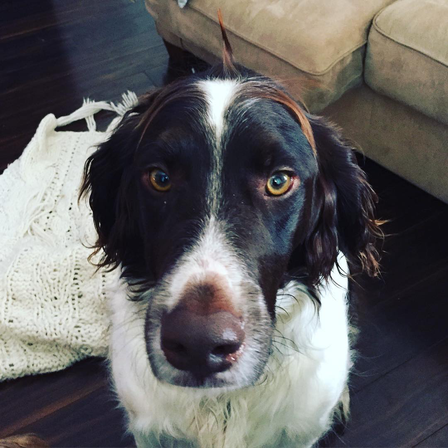

Actual: #style, #hair, #funny, #handsome, #lol, #sunday, #love
Prediction: #yellow, #cat, #green, #cute, #catsofinstagram
Prediction: #love, #family, #instadog, #beautiful, #dog
Prediction: #tired, #dog
Prediction: #love, #family, #cat, #beautiful, #cute
Prediction: #dog
Prediction: #yellow, #cat, #green, #cute, #flower
Prediction: #love, #family, #dog
Prediction: #yellow, #cat, #green
Prediction: #home
Prediction: #yellow


Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f2e4ad4eb10>> ignored


In [15]:
batched_data = batch_data(tag_list, 1, progress_bar=False)
batched_train_data, batched_test_data = create_splits(batched_data)
test_loader = get_loader(tag_list, batched_test_data, vocabulary, testing_transform, shuffle=True, num_workers=1)
for images, tags, image_ids in test_loader:
    if torch.cuda.is_available():
        images = images.cuda()
        tags = tags.cuda()
        
    image = Image.open("data/HARRISON/" + data_list[image_ids[0]])
    image = image.resize((448, 448), Image.ANTIALIAS)
    display(image)
    print("Actual: #" + ", #".join(tag_list[image_ids[0]].split(" "))[:-3])
    image_features = encoder(images)
    predictions = decoder.sample(image_features, beam_size=10, start_token=vocabulary("<SOS>"), end_token=vocabulary("<EOS>"))
    for prediction in predictions:
        tags = [vocabulary(tag) for tag in prediction[1][:-1]]
        print("Prediction: #" + ", #".join(tags))
    del images, tags
    break

## Finding Hamming Loss
We generate the hash tags for each image and find the average hamming loss of the model

In [ ]:
loss = 0
single_batched_data = batch_data(tag_list, 1, progress_bar=False)
single_batched_train_data, single_batched_test_data = create_splits(single_batched_data)
single_test_loader = get_loader(tag_list, single_batched_test_data, vocabulary, testing_transform, shuffle=True, num_workers=1)
for images, tags, image_ids in tqdm_notebook(single_test_loader):
    if torch.cuda.is_available():
        images = images.cuda()
        tags = tags.cuda()
        
    actual = nltk.tokenize.word_tokenize(tag_list[image_ids[0]].lower())
    image_features = encoder(images)
    predictions = decoder.sample(image_features, beam_size=10, start_token=vocabulary("<SOS>"), end_token=vocabulary("<EOS>"))
    best_prediction = predictions[0]
    actual_tags = [1 if i in actual else 0 for i in range(len(vocabulary))]
    predicted_tags = [1 if i in best_prediction[1] else 0 for i in range(len(vocabulary))]
    loss += hamming_loss(actual_tags, predicted_tags)
    del images, tags
print(loss / len(single_test_loader))